# 1. Data and Pre-processing

## 1.1 Libraries

In [1]:
import os
import gc
import cv2
import json
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import dump, load
import matplotlib.pyplot as plt
from collections import defaultdict
from timeit import default_timer as timer 
from going_modular.going_modular import utils, engine

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
import torch
import torchviz
from torch import nn
import torch.optim as optim
from torchinfo import summary
from torchsummary import summary as torchsummary
from torch.nn import functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, BatchSampler

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from torchmetrics.classification import MulticlassAUROC

In [4]:
print(torch.__version__)
print(torch.cuda.get_device_name())

2.0.1+cu118
NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## 1.2.1 Data Set class examples

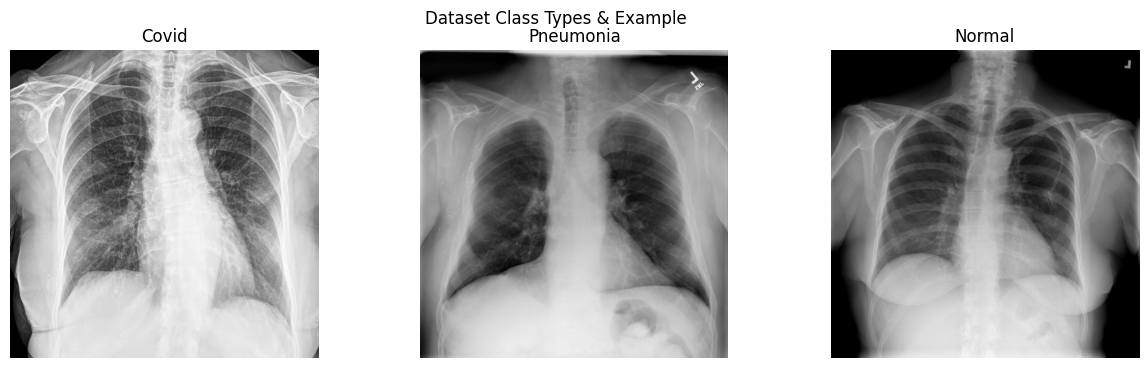

In [6]:
img1 = [f"data/train/covid/COVID-19 (2).png", 
        f"data/train/pneumonia/00000165_001.png",
        f"data/train/normal/00000005_003.png"]

fig = plt.figure(figsize = (15,4))

for i in range(0, 3):
    plt.subplot(1,3,i+1)
    plt.imshow(Image.open(img1[i]).convert('RGB'))
    plt.axis('off')

plt.subplot(1,3,1)
plt.title("Covid")

plt.subplot(1,3,2)
plt.title("Pneumonia")

plt.subplot(1,3,3)
plt.title("Normal")

plt.suptitle("Dataset Class Types & Example")
plt.show()

## 1.2.2 Dataset Loading

In [7]:
target_size = (224, 224)
batch_size = 20

In [8]:
def idx_to_label(id):
    labels = {0: 'covid', 1: 'normal', 2: 'pneumonia'}
    return labels[id]

def label_to_idx(label):
    idx = {'covid': 0, 'normal': 1, 'pneumonia': 2}
    return idx[label]

def idx_to_onehot(idx):
    onehot = {0: [1,0,0], 1: [0,1,0], 2: [0,0,1]}
    return onehot[idx]

In [9]:
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [10]:
# Load the datasets
trainset = datasets.ImageFolder('data/train', 
                                transform=transform) 

valset = datasets.ImageFolder('data/val',
                                transform=transform) 

testset = datasets.ImageFolder('data/test', 
                               transform=transform)

In [11]:
# Create data loaders 
train_loader = DataLoader(trainset, 
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=4, 
                        pin_memory=True)

val_loader = DataLoader(valset, 
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4, 
                        pin_memory=True)


test_loader = DataLoader(testset, 
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=4, 
                        pin_memory=True)

In [12]:
print("Training Data:",len(train_loader)*batch_size)
print("Validation Data:",len(val_loader)*batch_size)
print("Testing Data:",len(test_loader)*batch_size)

Training Data: 9000
Validation Data: 540
Testing Data: 300


# 2. CNN Model

In [13]:
class MobileNetV2Base(nn.Module):
    def __init__(self):
        super(MobileNetV2Base, self).__init__()
        
        # Get pretrained MobileNetV2 
        self.mobilenet = models.mobilenet_v2(pretrained=True)

        self.features = self.mobilenet.features
        self.classifier = nn.Linear(in_features=62720, out_features=3, bias=True)
    
    def forward(self, x):

        x = self.features(x)

        x = torch.flatten(x, 1)

        # Classifier
        x = self.classifier(x)
        return x

        return x

In [14]:
# Set the random seeds
torch.manual_seed(101)
torch.cuda.manual_seed(101)

In [15]:
grid_model = NeuralNetClassifier(
    module= MobileNetV2Base()
)

print(grid_model.initialize())

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MobileNetV2Base(
    (mobilenet): MobileNetV2(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResid

In [16]:
param_grid = {
    'optimizer__lr': [0.001, 0.01, 0.1],
    'optimizer': [optim.SGD, optim.RMSprop, optim.Adam, optim.Adadelta],
}

In [17]:
grid_len = int(len(train_loader)/2)

In [18]:
images = None
labels = None
for i in tqdm(range(grid_len)):
    images, labels = next(iter(train_loader))

100%|██████████| 225/225 [31:36<00:00,  8.43s/it]


In [19]:
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=5)
grid_result = grid.fit(images, labels)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0000           nan  1.2112
      2           nan       0.0000           nan  0.9432
      3           nan       0.0000           nan  0.9257
      4           nan       0.0000           nan  0.9402
      5           nan       0.0000           nan  0.9521
      6           nan       0.0000           nan  0.9968
      7           nan       0.0000           nan  0.9951
      8           nan       0.0000           nan  0.9936
      9           nan       0.0000           nan  1.0008
     10           nan       0.0000           nan  0.9413
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0000           nan  0.9257
      2           nan       0.0000           nan  0.9537
      3           nan       0.0000           nan  0.9259
      4           nan       0.0

In [20]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.250000 using {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'optimizer__lr': 0.1}
0.000000 (0.000000) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.001}
0.100000 (0.200000) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.01}
0.200000 (0.187083) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.1}
0.200000 (0.244949) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'optimizer__lr': 0.001}
0.200000 (0.244949) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'optimizer__lr': 0.01}
0.250000 (0.223607) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'optimizer__lr': 0.1}
0.150000 (0.200000) with: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.001}
0.200000 (0.187083) with: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.01}
0.050000 (0.100000) with: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.1}
0.000000 (0.000000) with: {'

In [18]:
mobilenet_model = MobileNetV2Base()

for param in mobilenet_model.features.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, mobilenet_model.parameters()),
                    lr=0.1)


summary(model=mobilenet_model, 
            input_size=(20, 3, 224, 224),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"]
    )

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2Base (MobileNetV2Base)             [20, 3, 224, 224]    [20, 3]              1,281,000            Partial
├─Sequential (features)                       [20, 3, 224, 224]    [20, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)               [20, 3, 224, 224]    [20, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                        [20, 3, 224, 224]    [20, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                   [20, 32, 112, 112]   [20, 32, 112, 112]   (64)                 False
│    │    └─ReLU6 (2)                         [20, 32, 112, 112]   [20, 32, 112, 112]   --                   --
│    └─InvertedResidual (1)                   [20, 32, 112, 112]   [20, 16, 112, 112]   --                   False
│    │    └─Sequential (conv)                 [20, 32, 112, 112]   [20, 16, 1

In [26]:
#Start the timer
from timeit import default_timer as timer 
start_time = timer()


# Ref: https://www.learnpytorch.io/05_pytorch_going_modular/
# Setup training and save the results
results = engine.train(model=mobilenet_model,
                       train_dataloader=train_loader,
                       test_dataloader=val_loader,
                       optimizer=optimizer,
                       loss_fn=criterion,
                       epochs=100,
                       device=device,
                       patience = 20)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

utils.save_model(model=mobilenet_model,
                 target_dir="models",
                 model_name="mobilenet_base_cnn_classifier.pth")
torch.save(results, 'Objects/mobilenet_base_results.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 517.7061 | train_acc: 0.8697 | test_loss: 767.2877 | test_acc: 0.7333
Validation Loss Improved: from inf to 767.2877
Epoch: 2 | train_loss: 205.6800 | train_acc: 0.9257 | test_loss: 181.2096 | test_acc: 0.9056
Validation Loss Improved: from 767.2877 to 181.2096
Epoch: 3 | train_loss: 169.6071 | train_acc: 0.9376 | test_loss: 919.6331 | test_acc: 0.7500
Validation Loss didn't Improve, patience: 1
Epoch: 4 | train_loss: 132.6413 | train_acc: 0.9504 | test_loss: 303.5094 | test_acc: 0.8944
Validation Loss didn't Improve, patience: 2
Epoch: 5 | train_loss: 133.8796 | train_acc: 0.9537 | test_loss: 207.1266 | test_acc: 0.9333
Validation Loss didn't Improve, patience: 3
Epoch: 6 | train_loss: 99.2768 | train_acc: 0.9643 | test_loss: 303.3531 | test_acc: 0.9074
Validation Loss didn't Improve, patience: 4
Epoch: 7 | train_loss: 80.5804 | train_acc: 0.9688 | test_loss: 270.3027 | test_acc: 0.9315
Validation Loss didn't Improve, patience: 5
Epoch: 8 | train_loss: 91.9643 |

In [15]:
results = torch.load('Objects/mobilenet_base_results.pth')

mobilenet_model = MobileNetV2Base().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, mobilenet_model.parameters()),
                    lr=0.1)

mobilenet_model.load_state_dict(torch.load('models/mobilenet_base_cnn_classifier.pth'))
mobilenet_model.eval()

MobileNetV2Base(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_s

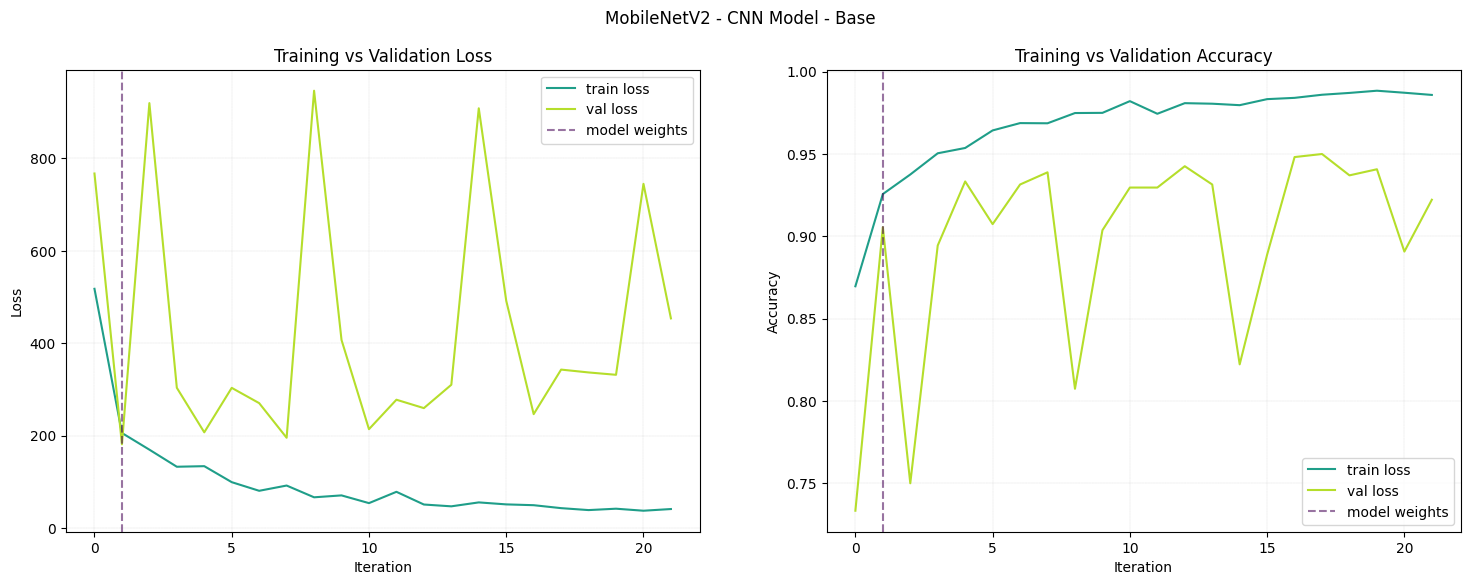

In [16]:
lowest = np.amin(results['test_loss'])
valloss_lowest = np.where(results['test_loss'] == lowest)

fig= plt.figure(figsize = (18, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(results['train_loss'], color = '#1f9e89')
ax1.plot(results['test_loss'], color = '#b5de2b')
ax1.set_title('Training vs Validation Loss')
ax1.axvline(x = valloss_lowest, color = '#440154', 
                  linestyle = '--', alpha = 0.55)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Iteration')
ax1.grid(color = 'grey', linestyle = '--', linewidth = 0.1)
ax1.legend(['train loss', 
            'val loss', 
            'model weights'
            ], loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(results['train_acc'], color = '#1f9e89')
ax2.plot(results['test_acc'], color = '#b5de2b')
ax2.axvline(x = valloss_lowest, color = '#440154', 
                  linestyle = '--', alpha = 0.55)
ax2.set_title('Training vs Validation Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Iteration')
ax2.grid(color = 'grey', linestyle = '--', linewidth = 0.1)
ax2.legend(['train loss', 
            'val loss', 
            'model weights'
            ], loc='lower right')

plt.suptitle("MobileNetV2 - CNN Model - Base")
plt.show()

In [17]:
predictions = []
y_test = []
for i, (images, labels) in enumerate(test_loader):
    with torch.inference_mode():
        predictions.append(mobilenet_model(images.to(device)))
        y_test.append(labels)


predictions = torch.stack(predictions, dim = 0)
y_test = torch.stack(y_test, dim = 0)

In [18]:
y_pred = predictions.reshape(-1, 3)
y_test = y_test.reshape(-1)
y_pred= torch.argmax(y_pred, axis=1)

In [19]:
assert y_pred.shape == y_test.shape

In [20]:
print(classification_report(y_test.cpu(), y_pred.cpu()))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       100
           1       0.89      0.96      0.92       100
           2       0.95      0.96      0.96       100

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



In [21]:
f1 = f1_score(y_test.cpu(), y_pred.cpu(), average='macro')
precision = precision_score(y_test.cpu(), y_pred.cpu(), average='macro')
recall = recall_score(y_test.cpu(), y_pred.cpu(), average='macro')
print(f'F1 Score: {f1:.4f}')
print(f'Precision Score: {precision:.4f}')
print(f'Recall Score: {recall:.4f}')

F1 Score: 0.9367
Precision Score: 0.9391
Recall Score: 0.9367


In [22]:
torch.cuda.empty_cache()

In [23]:
cm = confusion_matrix(y_test.cpu(), y_pred.cpu())
class_labels = ["covid", "normal", "pneumonia"]

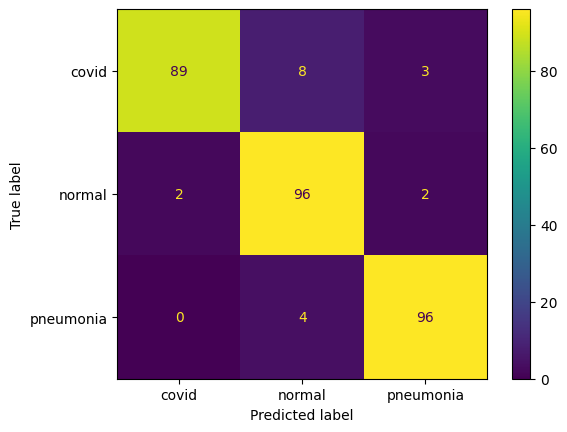

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.viridis)
plt.show()

In [25]:
metric = MulticlassAUROC(num_classes=3, average="macro", thresholds=None)
metric(predictions.reshape(-1, 3).cpu(), y_test.cpu()) 

tensor(0.9525)

# 3. Explainable AI

In [26]:
import xai_modules.integrated_gradients as ig
import xai_modules.gradcam as gradcam

In [27]:
image = Image.open('data/test/covid/COVID-3527.png').convert('RGB')
exp_target = label_to_idx('covid')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class: 0
Expected Class: 0
Model confidence: 21568.9512
Model sensitivity: 10086.7197
Integrated_Grad sensitivity: 0.0226


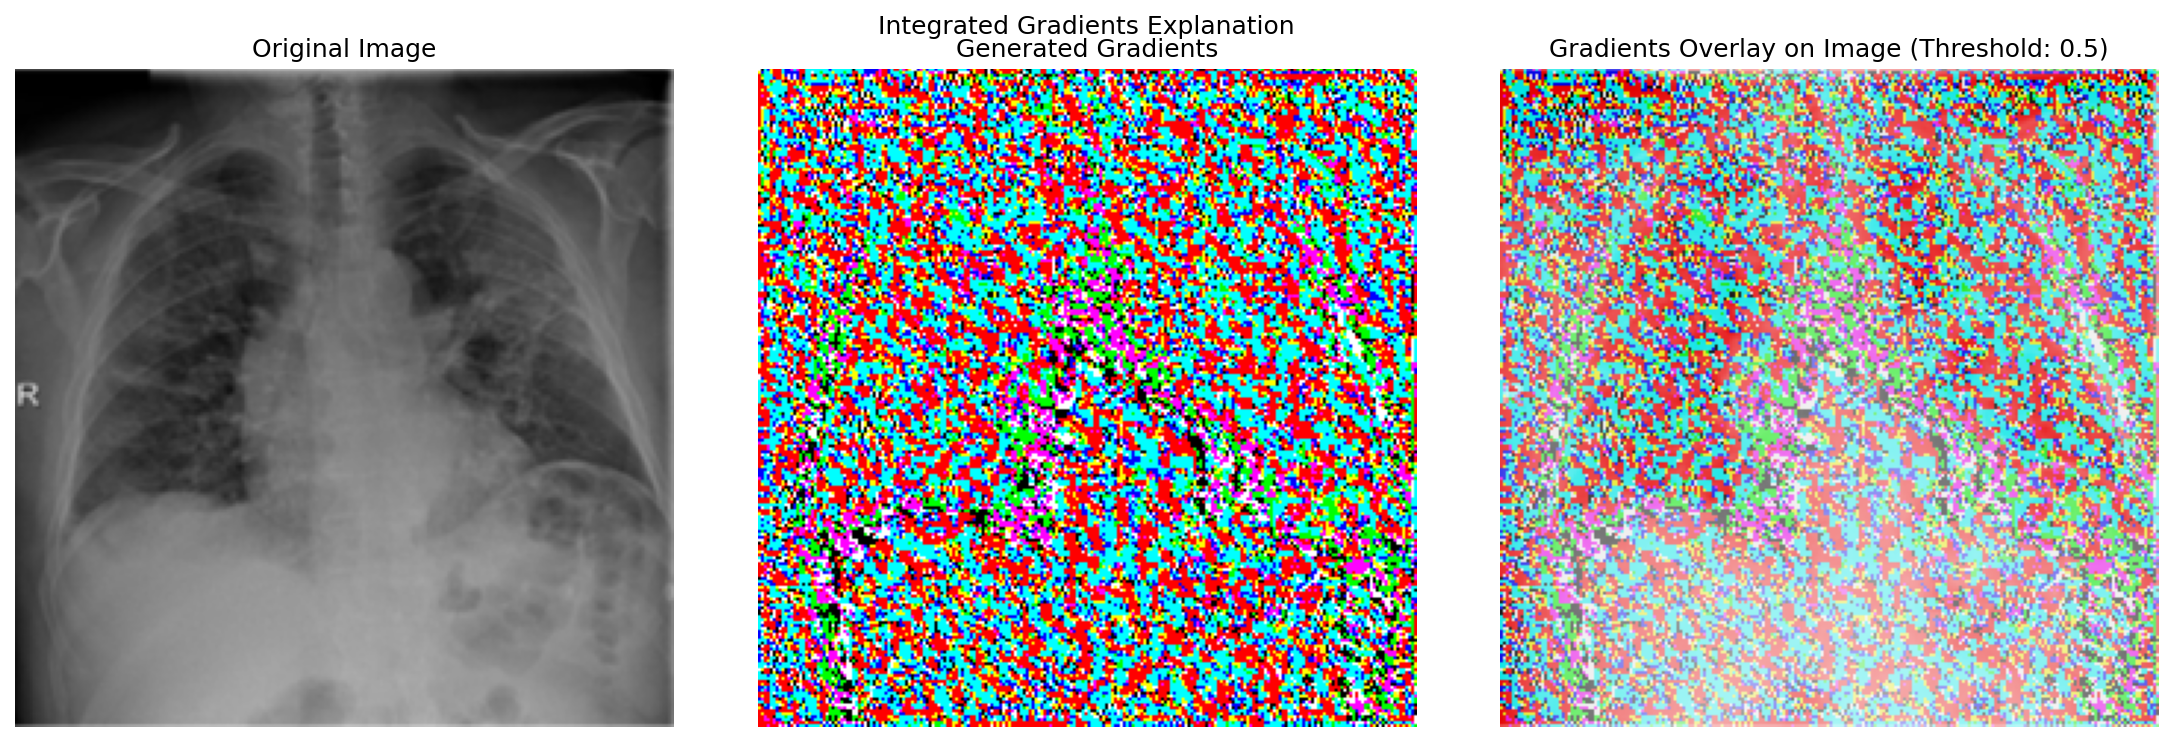

In [28]:
# Load model, image, etc
ig.visualize_integrated_grads(image, 
                            mobilenet_model, 
                            exp_target = exp_target,
                            ig_steps = 50,
                            grad_threshold = 0.5,
                            img_size = target_size, 
                            device = device)

Predicted Class: 0
Expected Class: 0
Model confidence: 21568.9512
Model sensitivity: 10086.7197


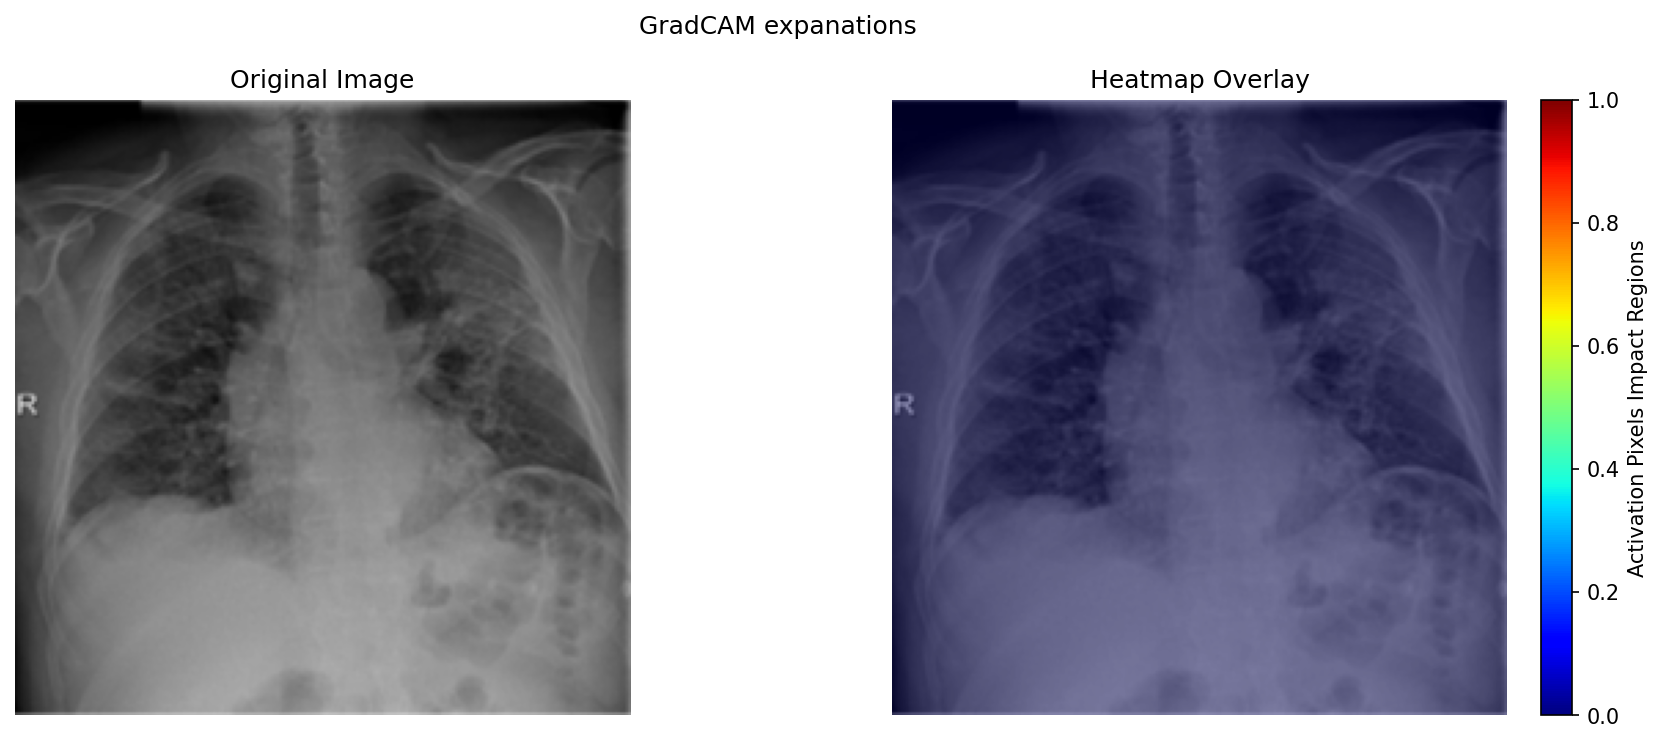

In [29]:
gradcam.visualize_gradcam(model = mobilenet_model,
                          model_type='CNN',
                          image = image,
                          exp_target = exp_target,
                          loss_fn = criterion,
                          final_layer = mobilenet_model.features[-1],
                          img_size = target_size,
                          device = device)